In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import prod

import jax
import jax.numpy as jnp
import jax_cfd.base as base
import jax_cfd.collocated as collocated
import jax_cfd.data.xarray_utils as xru
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import xarray

import scripts.dns_specifics as DS

funcutils = base.funcutils

np.random.seed(42)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Data

In [3]:
base_shape = (128, 128)
axis_array = 2 * [np.linspace(0, 2*np.pi, 128+1)[:-1]]
dx = axis_array[0][1]-axis_array[0][0]
dy = axis_array[1][1]-axis_array[1][0]

## Generate Data

In [4]:
# https://github.com/google/jax-cfd/blob/main/notebooks/spectral_forced_turbulence.ipynb
def run_collocated(size, seed=0, inner_steps=25, outer_steps=100):
  density = 1.
  viscosity = 1e-3
  max_velocity = 2.0
  cfl_safety_factor = 0.5

  # Define the physical dimensions of the simulation.
  grid = base.grids.Grid((size, size),
                         domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

  # Choose a time step.
  dt = base.equations.stable_time_step(
      max_velocity, cfl_safety_factor, viscosity, grid)

  # Construct a random initial velocity. The `filtered_velocity_field` function
  # ensures that the initial velocity is divergence free and it filters out
  # high frequency fluctuations.
  v0 = collocated.initial_conditions.filtered_velocity_field(
      jax.random.PRNGKey(seed), grid, max_velocity)

  # Define a step function and use it to compute a trajectory.
  # For linear convection, add the argument to semi_implicit_navier_stokes:
  #   `convect=collocated.advection.convect_linear`
  step_fn = funcutils.repeated(
      collocated.equations.semi_implicit_navier_stokes(
          density=density, viscosity=viscosity, dt=dt, grid=grid),
      steps=inner_steps)
  rollout_fn = jax.jit(funcutils.trajectory(step_fn, outer_steps))
  _, trajectory = jax.device_get(rollout_fn(v0))

  # load into xarray for visualization and analysis
  ds = xarray.Dataset(
      {
          'u': (('time', 'x', 'y'), trajectory[0].data),
          'v': (('time', 'x', 'y'), trajectory[1].data),
      },
      coords={
          'x': grid.axes()[0],
          'y': grid.axes()[1],
          'time': dt * inner_steps * np.arange(outer_steps)
      }
  )
  return ds

def vorticity(ds):
  return (ds.v.differentiate('x')
          - ds.u.differentiate('y')).rename('vorticity')

In [5]:
%%time
snapshots = []
for i in range(20):
    ds_collocated_128 = run_collocated(size=128)
    vortdata = ds_collocated_128.pipe(vorticity)  # .thin(time=10)
    snaps = torch.Tensor(np.array(vortdata))[10:]
    for snap in snaps:
        vort = snap.detach().cpu().numpy()
        vort = DS.all_syms(vort,
            base_shape=base_shape,
            dx=dx,
            dy=dy,
            x_shift=2*np.pi*np.random.rand(),
            m=np.random.randint(326),
            n=4)
        snapshots.append(vort)
snapshots = torch.Tensor(snapshots).unsqueeze(1)
snapshots /= snapshots.abs().max()

2022-05-03 16:59:00.341312: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-03 16:59:00.376606: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-03 16:59:00.417052: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

CPU times: user 4min 3s, sys: 586 ms, total: 4min 3s
Wall time: 3min 47s


<timed exec>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


# Visualize Data

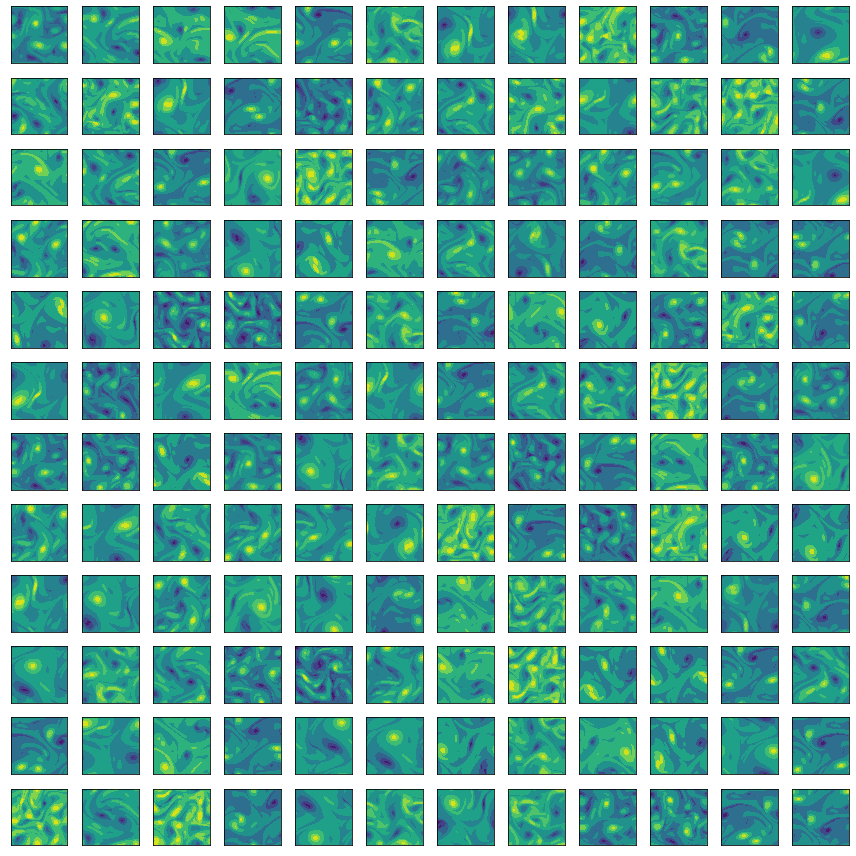

In [6]:
# Visualize select snapshots
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (12, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[np.random.randint(snapshots.shape[0])][0])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

# Save Data

In [7]:
torch.save(snapshots, './data/simulated_data.obj')